In [1]:
import pandas as pd
from pyvis.network import Network
import networkx as nx
import random
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np


In [9]:
df_tsv = pd.read_csv('interactions.tsv', sep='\t')
print(df_tsv.head())

/var/folders/bv/8czfhhn97n52x2zdndfhhxkr0000gn/T/ipykernel_2692/1721271714.py:1: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,37,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65,66,67,68,69,70,71,72,73,74,75,76,77,80,81,82,84,85,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tsv = pd.read_csv('interactions.tsv', sep='\t')


   sourceTaxonId                                     sourceTaxonIds  \
0     EOL:728616  COL:8FMKV | EOL:728616 | GBIF:1460950 | ITIS:6...   
1     EOL:761415  COL:6836M | EOL:761415 | GBIF:1463179 | ITIS:6...   
2     EOL:728928                          EOL:728928 | WD:Q13494237   
3     EOL:728675  COL:6Q3BL | EOL:728675 | GBIF:5056615 | NCBI:6...   
4  IRMNG:1365935                                      IRMNG:1365935   

             sourceTaxonName sourceTaxonRank  \
0  Winthemia quadripustulata         species   
1     Argyrophylax albincisa         species   
2      Chetogena claripennis         species   
3   Leschenaultia leucophrys         species   
4                    Mericia           genus   

                                sourceTaxonPathNames  \
0  Life | Cellular Organisms | Eukaryota | Opisth...   
1  Life | Cellular Organisms | Eukaryota | Opisth...   
2  Life | Cellular Organisms | Eukaryota | Opisth...   
3  Life | Cellular Organisms | Eukaryota | Opisth...   
4  A

In [10]:
# Filter dataset for mammal on mammal "preys on" interactions 

df_preys_on_mammal = df_tsv[
    (df_tsv['interactionTypeName'] == 'preysOn') & 
    (df_tsv['sourceTaxonClassName'] == 'Mammalia') & 
    (df_tsv['targetTaxonClassName'] == 'Mammalia')
]
print(f"Number of mammal preysOn interactions: {len(df_preys_on_mammal)}")

Number of mammal preysOn interactions: 3552


In [11]:
# Optional: 
# Sometimes the Dataset Contains only the Species Name i.e. Rodentia, most of the time it contains the sub species, for now we just keep it like this, 
# and expect the LLM can handle this, but if necessary this cell can be used to remove them 

#df_preys_on_mammal = df_preys_on_mammal[~df_preys_on_mammal['sourceTaxonName'].str.contains('^[^\s]+$', regex=True) & ~df_preys_on_mammal['targetTaxonName'].str.contains('^[^\s]+$', regex=True)]

In [12]:
# Save smaller dataset 
df_preys_on_mammal.to_csv('mammal_prey_interactions.csv')

In [2]:
# Open Dataset 
df_preys_on_mammal = pd.read_csv('mammal_prey_interactions.csv')

In [3]:
%%capture
# Create directed graph of GloBi subset 
G = nx.DiGraph()

# Add edges from source to target taxa
for _, row in df_preys_on_mammal.iterrows():
    G.add_edge(row['sourceTaxonName'], row['targetTaxonName'])

# Initialize Pyvis Network
net = Network(height="1000px", width="100%", directed=True, notebook=True)

# Add nodes and edges to Pyvis Network
for node in G.nodes():
    net.add_node(node, label=node, size=10)  # Fixed size for simplicity

for edge in G.edges():
    net.add_edge(*edge)

# Generate the interactive graph in the working directory
#net.show("predator_prey_network.html")

In [4]:
print(f"Number of nodes in G: {G.number_of_nodes()}")
print(f"Number of edges in G: {G.number_of_edges()}")

Number of nodes in G: 706
Number of edges in G: 1157


In [12]:
# create sub graph 

def create_subgraph(G, root_species, depth=5, n_nodes_lowerbound=2, n_nodes_upperbound=15):

    max_nodes = np.random.randint(n_nodes_lowerbound,n_nodes_upperbound)

    nodes_to_include = {root_species}
    frontier = [(root_species, 0)]  # (node, depth)
    
    while frontier and len(nodes_to_include) < max_nodes:
        idx = random.randrange(len(frontier))
        current_node, current_depth = frontier.pop(idx)
        
        if current_depth >= depth:
            continue
            
        predecessors = list(set(G.predecessors(current_node)) - nodes_to_include)
        successors = list(set(G.successors(current_node)) - nodes_to_include)
        
        random.shuffle(predecessors)
        random.shuffle(successors)
        
        pred_idx = 0
        succ_idx = 0
        
        while (len(nodes_to_include) < max_nodes and 
               (pred_idx < len(predecessors) or succ_idx < len(successors))):
            
            if pred_idx < len(predecessors):
                new_node = predecessors[pred_idx]
                if new_node not in nodes_to_include:
                    nodes_to_include.add(new_node)
                    frontier.append((new_node, current_depth + 1))
                pred_idx += 1
                
            if len(nodes_to_include) >= max_nodes:
                break
                
            if succ_idx < len(successors):
                new_node = successors[succ_idx]
                if new_node not in nodes_to_include:
                    nodes_to_include.add(new_node)
                    frontier.append((new_node, current_depth + 1))
                succ_idx += 1
    
    return G.subgraph(nodes_to_include).copy()

def calculate_graph_depth(G):
    max_depth = 0
    undirected = G.to_undirected()
    
    for source in G.nodes():
        for target in G.nodes():
            if source != target:
                try:
                    path_length = nx.shortest_path_length(undirected, source, target)
                    max_depth = max(max_depth, path_length)
                except nx.NetworkXNoPath:
                    continue
    
    return max_depth

def is_duplicate_graph(new_graph_data, existing_graphs):

    new_nodes = set(new_graph_data["nodes"])
    new_edges = set(tuple(edge) for edge in new_graph_data["edges"])
    
    for graph in existing_graphs:
        existing_nodes = set(graph["nodes"])
        existing_edges = set(tuple(edge) for edge in graph["edges"])
        
        if new_nodes == existing_nodes and new_edges == existing_edges:
            return True
    
    return False

def export_subgraphs(G, num_subgraphs=10, max_nodes=10, max_depth=5, filename=None, max_attempts=1000):

    subgraphs_data = []
    attempts = 0
    valid_subgraphs = 0
    
    while valid_subgraphs < num_subgraphs and attempts < max_attempts:
        attempts += 1
        
        # Randomly select root species
        root_species = random.choice(list(G.nodes()))
        
        # Create subgraph
        subgraph = create_subgraph(G, root_species)
        
        # Skip if subgraph has only one node
        if len(subgraph.nodes()) <= 1:
            continue
            
        # Calculate actual depth
        actual_depth = calculate_graph_depth(subgraph)
        
        # Create graph data dictionary
        graph_data = {
            "id": valid_subgraphs,
            "root_species": root_species,
            "num_nodes": len(subgraph.nodes()),
            "num_edges": len(subgraph.edges()),
            "max_depth": actual_depth,
            "nodes": list(subgraph.nodes()),
            "edges": list(subgraph.edges()),
            "creation_parameters": {
                "max_nodes": max_nodes,
                "max_depth": max_depth
            }
        }
        
        # Check if it is a duplicate graph
        if not is_duplicate_graph(graph_data, subgraphs_data):
            subgraphs_data.append(graph_data)
            valid_subgraphs += 1
    
    # Generate filename if none provided
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"relation_subgraphs_{timestamp}.json"
    
    # Save to JSON file
    with open(filename, 'w') as f:
        json.dump({
            "metadata": {
                "original_graph_nodes": len(G.nodes()),
                "original_graph_edges": len(G.edges()),
                "requested_subgraphs": num_subgraphs,
                "generated_subgraphs": valid_subgraphs,
                "total_attempts": attempts,
                "creation_date": datetime.now().isoformat()
            },
            "subgraphs": subgraphs_data
        }, f, indent=2)
    
    if valid_subgraphs < num_subgraphs:
        print(f"Warning: Only generated {valid_subgraphs} unique subgraphs out of {num_subgraphs} requested after {attempts} attempts")
    
    return filename

export_subgraphs(G, num_subgraphs=5000, max_depth=5) # max_nodes is defined in create subgraph, G := Graph object 


'relation_subgraphs_20250127_215654.json'

In [3]:
# As of right now we dont need to save or load the graphs, but might be useful for later 

def load_subgraphs_from_json(filename):

    with open(filename, 'r') as f:
        data = json.load(f)
        
    graphs = {}
    
    # Process each subgraph
    for graph_data in data['subgraphs']:
        # Create directed graph
        G = nx.DiGraph()
        
        # Add nodes
        G.add_nodes_from(graph_data['nodes'])
        
        # Add edges
        G.add_edges_from(graph_data['edges'])
        
        # Store graph and its metadata
        graphs[graph_data['id']] = {
            'graph': G,
            'max_depth': graph_data['max_depth'],
            'num_nodes': graph_data['num_nodes'],
            'num_edges': graph_data['num_edges'],
        }
    
    return graphs

graphs = load_subgraphs_from_json('relation_subgraphs_20250127_214847.json')



In [4]:
# As of now, we delete self loops, and dont include cannibalism t

for id, graph in graphs.items(): 

    G = graph["graph"]
    self_loops = list(nx.selfloop_edges(G))
    
    # Remove all self-loops
    G.remove_edges_from(self_loops)

    graph["num_edges"] = G.number_of_edges() 
    
    if len(self_loops) > 0:
        print(f"Removed {len(self_loops)} self-loops from graph {id}")

Removed 3 self-loops from graph 1
Removed 1 self-loops from graph 2
Removed 4 self-loops from graph 3
Removed 2 self-loops from graph 4
Removed 1 self-loops from graph 5
Removed 2 self-loops from graph 7
Removed 1 self-loops from graph 8
Removed 3 self-loops from graph 9
Removed 4 self-loops from graph 11
Removed 1 self-loops from graph 12
Removed 1 self-loops from graph 14
Removed 4 self-loops from graph 15
Removed 1 self-loops from graph 16
Removed 3 self-loops from graph 17
Removed 1 self-loops from graph 19
Removed 4 self-loops from graph 21
Removed 3 self-loops from graph 22
Removed 3 self-loops from graph 23
Removed 1 self-loops from graph 24
Removed 4 self-loops from graph 25
Removed 3 self-loops from graph 26
Removed 3 self-loops from graph 27
Removed 4 self-loops from graph 28
Removed 4 self-loops from graph 29
Removed 1 self-loops from graph 30
Removed 3 self-loops from graph 31
Removed 3 self-loops from graph 32
Removed 1 self-loops from graph 33
Removed 4 self-loops from gr

In [5]:
# We Remove cyclic graphs beacause they are not solvable  
acyclic_graphs = {graph_id: graph_data for graph_id, graph_data in graphs.items() if nx.is_directed_acyclic_graph(graph_data['graph'])}

# Update the graphs dictionary to only include acyclic graphs
graphs = acyclic_graphs


# Print the updated count of acyclic graphs
print(f"Number of acyclic graphs: {len(graphs)}")



Number of acyclic graphs: 624


In [6]:
def describe_subgraph(graph):
    # Create mapping of species to pseudonyms
    species = sorted(list(graph.nodes()))  # Sort for consistent pseudonym assignment
    pseudonym_map = {species[i]: f"Animal {chr(65+i)}" for i in range(len(species))}
    
    def generate_description(use_pseudonyms=False):
        description = []
        # Get all nodes that have outgoing edges (predators)
        predators = [n for n in graph.nodes() if graph.out_degree(n) > 0]
        
        for predator in predators:
            # Get all prey for this predator
            prey = list(graph.successors(predator))
            
            # Use pseudonyms if requested
            pred_name = pseudonym_map[predator] if use_pseudonyms else predator
            prey_names = [pseudonym_map[p] if use_pseudonyms else p for p in prey]
            
            if len(prey) == 1:
                description.append(f"{pred_name} preys on {prey_names[0]}")
            elif len(prey) == 2:
                description.append(f"{pred_name} preys on {prey_names[0]} and {prey_names[1]}")
            elif len(prey) > 2:
                prey_str = ", ".join(prey_names[:-1]) + f" and {prey_names[-1]}"
                description.append(f"{pred_name} preys on {prey_str}")
                
        return ". ".join(description) + "."
    
    # Generate both versions of the description
    regular_description = generate_description(use_pseudonyms=False)
    pseudonym_description = generate_description(use_pseudonyms=True)
    
    # Create a mapping reference
    mapping_ref = [f"{pseudonym_map[species]}: {species}" for species in species]
    
    return {
        'regular': regular_description,
        'pseudonym': pseudonym_description,
        'animals':  ", ".join(map(str, list(graph.nodes()))),  # Simple list of all animals
        'mapping': mapping_ref
    }

In [ ]:
'''
There are quite A few errors in the GloBi Dataset i.e. where it states that Marmota marmota (Marmot) preys on Homo sapiens. For now we
don't care about these type of errors, since they wont affect the comparison between models and they should be rare enough to not change the scores 
significantly.  
'''

In [7]:
# Super messy way to find graphs we can actually solve. 
from z3 import *


def analyze_subgraph_impact(edges, start_species, change=1):
    species = set()
    predators = {}
    prey = {}
    for pred, p in edges:
        species.add(pred)
        species.add(p)
        predators.setdefault(p, []).append(pred)
        prey.setdefault(pred, []).append(p)
    
    # Ensure start_species is in the species set
    if start_species not in species:
       # raise ValueError(f"Start species '{start_species}' is not in the graph.")
       return

    solver = Solver()
    changes = {s: Int(f'change_{s}') for s in species}
    for s in species:
        solver.add(Or(changes[s] == -1, changes[s] == 0, changes[s] == 1))
    
    solver.add(changes[start_species] == change)
    
    for s in species:
        if s == start_species:
            continue
        species_predators = predators.get(s, [])
        species_prey = prey.get(s, [])
        if species_predators and species_prey:
            pred_sum = Sum([changes[p] for p in species_predators])
            prey_sum = Sum([changes[p] for p in species_prey])
            solver.add(
                If(prey_sum > pred_sum, changes[s] == 1,
                If(prey_sum < pred_sum, changes[s] == -1,
                changes[s] == 0))
            )
        elif species_predators:
            pred_sum = Sum([changes[p] for p in species_predators])
            solver.add(
                If(pred_sum > 0, changes[s] == -1,
                If(pred_sum < 0, changes[s] == 1,
                changes[s] == 0))
            )
        elif species_prey:
            prey_sum = Sum([changes[p] for p in species_prey])
            solver.add(
                If(prey_sum > 0, changes[s] == 1,
                If(prey_sum < 0, changes[s] == -1,
                changes[s] == 0))
            )
    
    if solver.check() == sat:
        model = solver.model()
        return {s: model[changes[s]].as_long() for s in species}
    else:
        return solver

def find_problematic_edges_with_graphs(edges, graph_id):
    fixed_edges = edges.copy()
    removed_edges = []
    problematic_constraints = []
    tested_edges = set()
    solutions = {}

    for start_species in set(pred for pred, _ in edges):
        solver_or_result = analyze_subgraph_impact(fixed_edges, start_species, 1)
        if isinstance(solver_or_result, Solver):
            problematic_edges = []
            for edge in fixed_edges:
                if edge in tested_edges:
                    continue
                temp_edges = fixed_edges.copy()
                temp_edges.remove(edge)
                
                # Ensure the start_species is still in the graph
                temp_species = set(pred for pred, _ in temp_edges).union(set(prey for _, prey in temp_edges))
                if start_species not in temp_species:
                    continue  # Skip if the species is no longer in the graph
                
                test_solver = analyze_subgraph_impact(temp_edges, start_species, 1)
                if isinstance(test_solver, Solver):
                    continue
                else:
                    problematic_edges.append(edge)
                tested_edges.add(edge)
            
            for edge in problematic_edges:
                if edge in fixed_edges:
                    fixed_edges.remove(edge)
                    removed_edges.append(edge)
            problematic_constraints.append(start_species)
        else:
            solutions[start_species] = solver_or_result  # Store valid solutions for the species
    
    # Generate solutions for the fixed graph
    all_species = set(pred for pred, _ in fixed_edges).union(set(prey for _, prey in fixed_edges))
    for species in all_species:
        solver_or_result = analyze_subgraph_impact(fixed_edges, species, 1)
        if not isinstance(solver_or_result, Solver):
            solutions[species] = solver_or_result

    # Convert fixed edges to a NetworkX graph
    fixed_graph = nx.DiGraph()
    fixed_graph.add_edges_from(fixed_edges)

    return {
        'fixed_graph': fixed_graph,
        'removed_edges': removed_edges,
        'problematic_constraints': problematic_constraints,
        'solutions': solutions
    }

# Main processing loop for multiple graphs
def process_graphs(graphs):
    fixed_graphs = {}
    solutions_dict = {}

    for graph_id, graph_data in graphs.items():
        if not hasattr(graph_data["graph"], 'edges'):
            print(f"Graph {graph_id} is malformed. Skipping...")
            continue

        edges = list(graph_data["graph"].edges())
        print(f"Processing Graph {graph_id}...")

        # Validate edges before processing
        if not isinstance(edges, list) or not edges:
            print(f"Graph {graph_id} has no edges or edges are malformed. Skipping...")
            continue

        result = find_problematic_edges_with_graphs(edges, graph_id)

        # Store the fixed graph and solutions
        fixed_graphs[graph_id] = result['fixed_graph']
        solutions_dict[graph_id] = result['solutions']

        print(f"Graph {graph_id}: Fixed graph and solutions processed.")

    return fixed_graphs, solutions_dict



fixed_graphs, solutions = process_graphs(graphs)

for graph_id in fixed_graphs:
    print(f"Graph ID: {graph_id}")
    print("Fixed Graph Edges:", list(fixed_graphs[graph_id].edges()))
    print("Solutions:", solutions[graph_id])

Processing Graph 0...
Graph 0: Fixed graph and solutions processed.
Processing Graph 2...
Graph 2: Fixed graph and solutions processed.
Processing Graph 5...
Graph 5: Fixed graph and solutions processed.
Processing Graph 6...
Graph 6: Fixed graph and solutions processed.
Processing Graph 7...
Graph 7: Fixed graph and solutions processed.
Processing Graph 8...
Graph 8: Fixed graph and solutions processed.
Processing Graph 9...
Graph 9: Fixed graph and solutions processed.
Processing Graph 10...
Graph 10: Fixed graph and solutions processed.
Processing Graph 12...
Graph 12: Fixed graph and solutions processed.
Processing Graph 13...
Graph 13: Fixed graph and solutions processed.
Processing Graph 14...
Graph 14: Fixed graph and solutions processed.
Processing Graph 16...
Graph 16: Fixed graph and solutions processed.
Processing Graph 18...
Graph 18: Fixed graph and solutions processed.
Processing Graph 19...
Graph 19: Fixed graph and solutions processed.
Processing Graph 20...
Graph 20: F

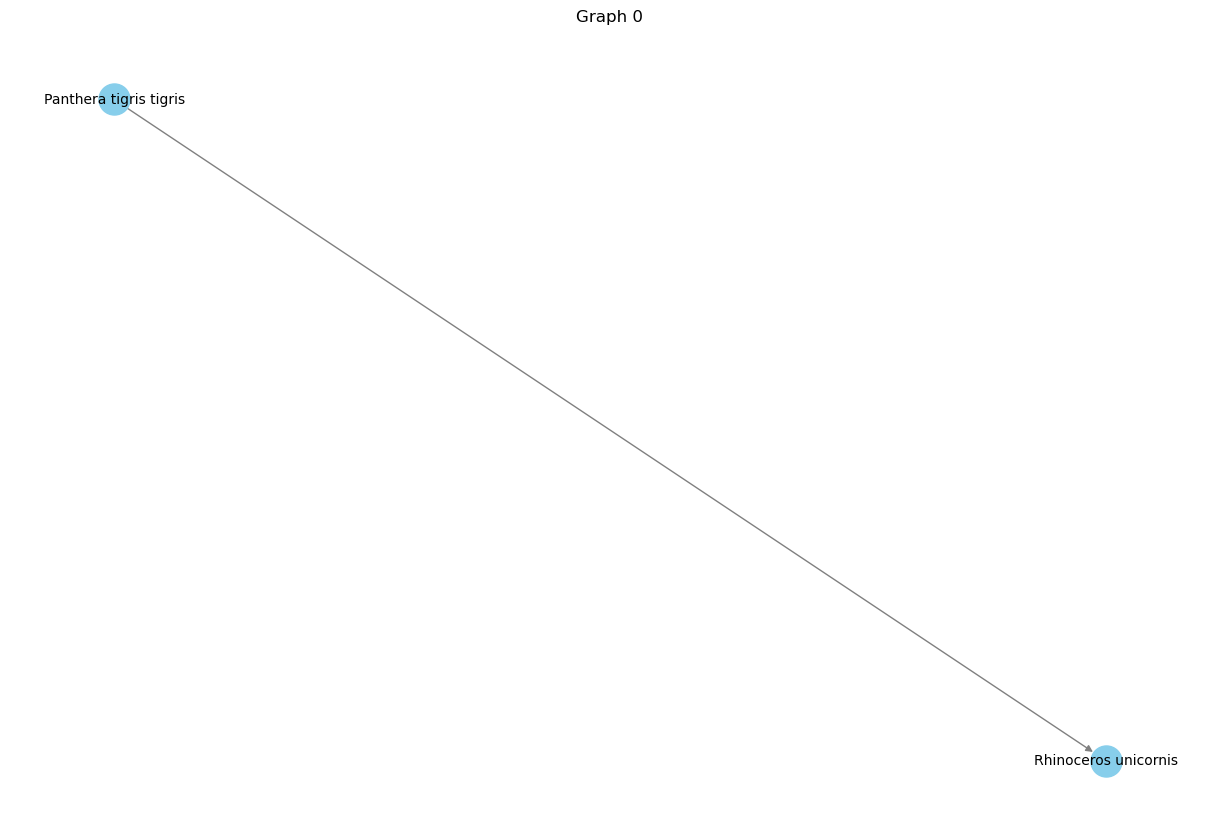

{'Panthera tigris tigris': {'Rhinoceros unicornis': -1, 'Panthera tigris tigris': 1}, 'Rhinoceros unicornis': {'Rhinoceros unicornis': 1, 'Panthera tigris tigris': 1}}
{0: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2bb50>, 2: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b2b0>, 5: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b040>, 6: <networkx.classes.digraph.DiGraph object at 0x7b41d2ff88e0>, 7: <networkx.classes.digraph.DiGraph object at 0x7b41d21759d0>, 8: <networkx.classes.digraph.DiGraph object at 0x7b41d2175a00>, 9: <networkx.classes.digraph.DiGraph object at 0x7b41d21755b0>, 10: <networkx.classes.digraph.DiGraph object at 0x7b41d21755e0>, 12: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fa0>, 13: <networkx.classes.digraph.DiGraph object at 0x7b41d2175b20>, 14: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fd0>, 16: <networkx.classes.digraph.DiGraph object at 0x7b41d2175d90>, 18: <networkx.classes.digraph.DiGraph object at 0x7b41d217

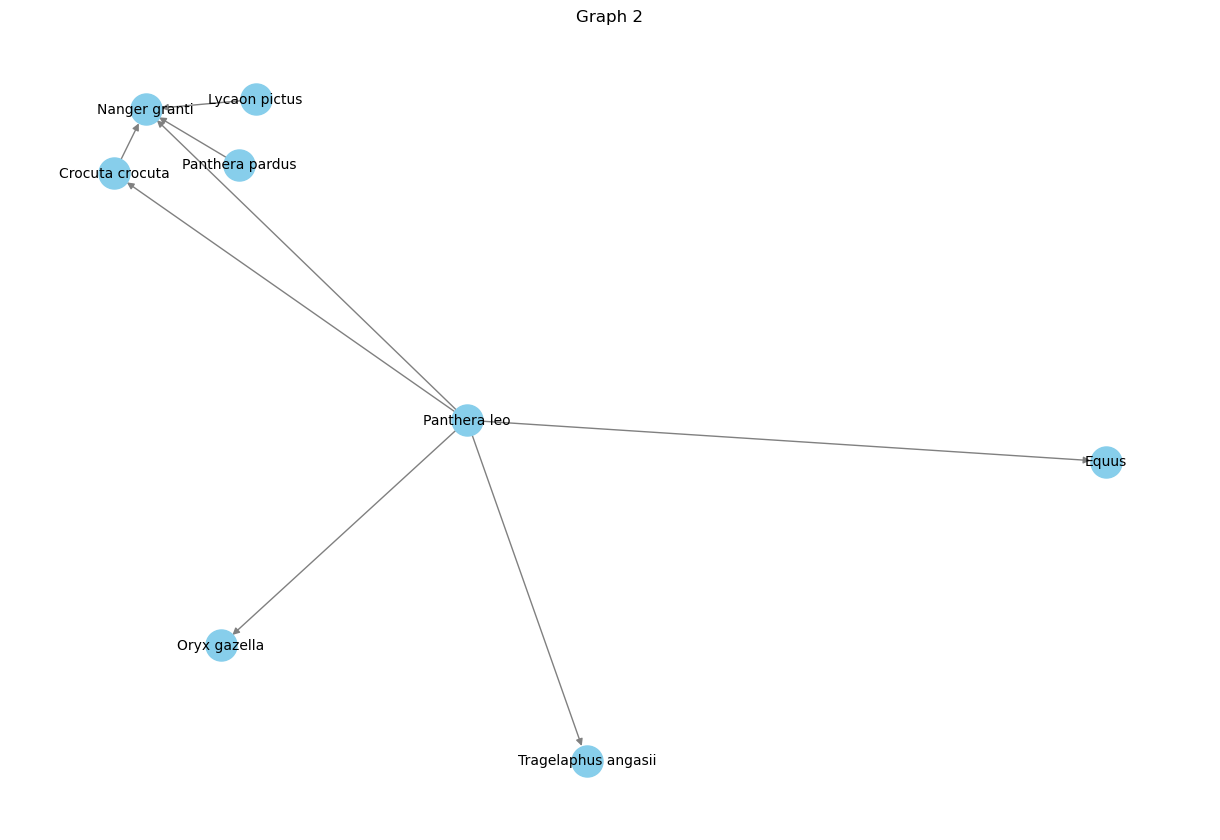

{'Canis aureus': None, 'Acinonyx jubatus': None, 'Panthera leo': {'Panthera pardus': 0, 'Crocuta crocuta': -1, 'Equus': -1, 'Tragelaphus angasii': -1, 'Lycaon pictus': 0, 'Oryx gazella': -1, 'Panthera leo': 1, 'Nanger granti': 0}}
{0: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2bb50>, 2: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b2b0>, 5: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b040>, 6: <networkx.classes.digraph.DiGraph object at 0x7b41d2ff88e0>, 7: <networkx.classes.digraph.DiGraph object at 0x7b41d21759d0>, 8: <networkx.classes.digraph.DiGraph object at 0x7b41d2175a00>, 9: <networkx.classes.digraph.DiGraph object at 0x7b41d21755b0>, 10: <networkx.classes.digraph.DiGraph object at 0x7b41d21755e0>, 12: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fa0>, 13: <networkx.classes.digraph.DiGraph object at 0x7b41d2175b20>, 14: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fd0>, 16: <networkx.classes.digraph.DiGraph object at 0x7b41d2175d

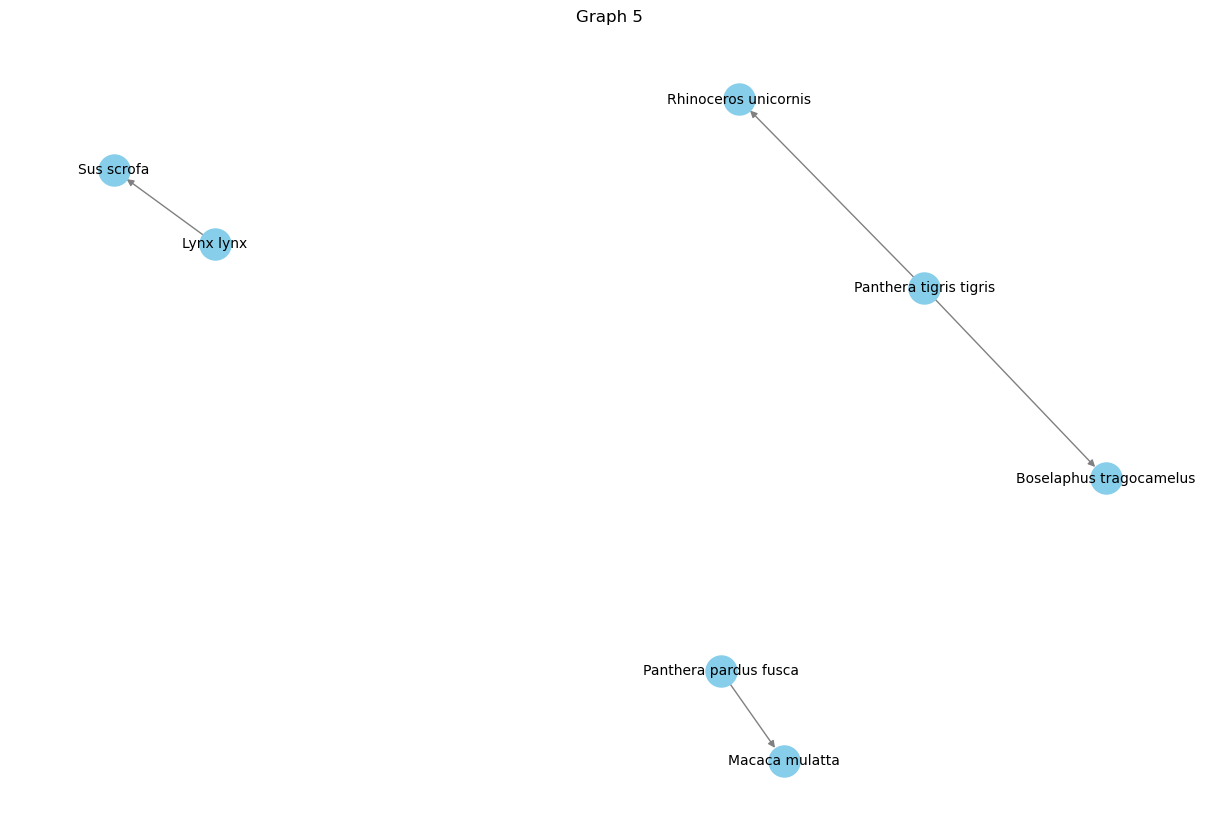

{'Panthera pardus fusca': {'Rhinoceros unicornis': 0, 'Boselaphus tragocamelus': 0, 'Sus scrofa': 0, 'Panthera tigris tigris': 0, 'Macaca mulatta': -1, 'Lynx lynx': 0, 'Panthera pardus fusca': 1}, 'Lynx lynx': {'Rhinoceros unicornis': 0, 'Boselaphus tragocamelus': 0, 'Sus scrofa': -1, 'Panthera tigris tigris': 0, 'Macaca mulatta': 0, 'Lynx lynx': 1, 'Panthera pardus fusca': 0}, 'Sus scrofa': {'Rhinoceros unicornis': 0, 'Boselaphus tragocamelus': 0, 'Sus scrofa': 1, 'Panthera tigris tigris': 0, 'Macaca mulatta': 0, 'Lynx lynx': 1, 'Panthera pardus fusca': 0}, 'Panthera tigris tigris': {'Rhinoceros unicornis': -1, 'Boselaphus tragocamelus': -1, 'Sus scrofa': 0, 'Panthera tigris tigris': 1, 'Macaca mulatta': 0, 'Lynx lynx': 0, 'Panthera pardus fusca': 0}, 'Macaca mulatta': {'Rhinoceros unicornis': 0, 'Boselaphus tragocamelus': 0, 'Sus scrofa': 0, 'Panthera tigris tigris': 0, 'Macaca mulatta': 1, 'Lynx lynx': 0, 'Panthera pardus fusca': 1}}
{0: <networkx.classes.digraph.DiGraph object at 0

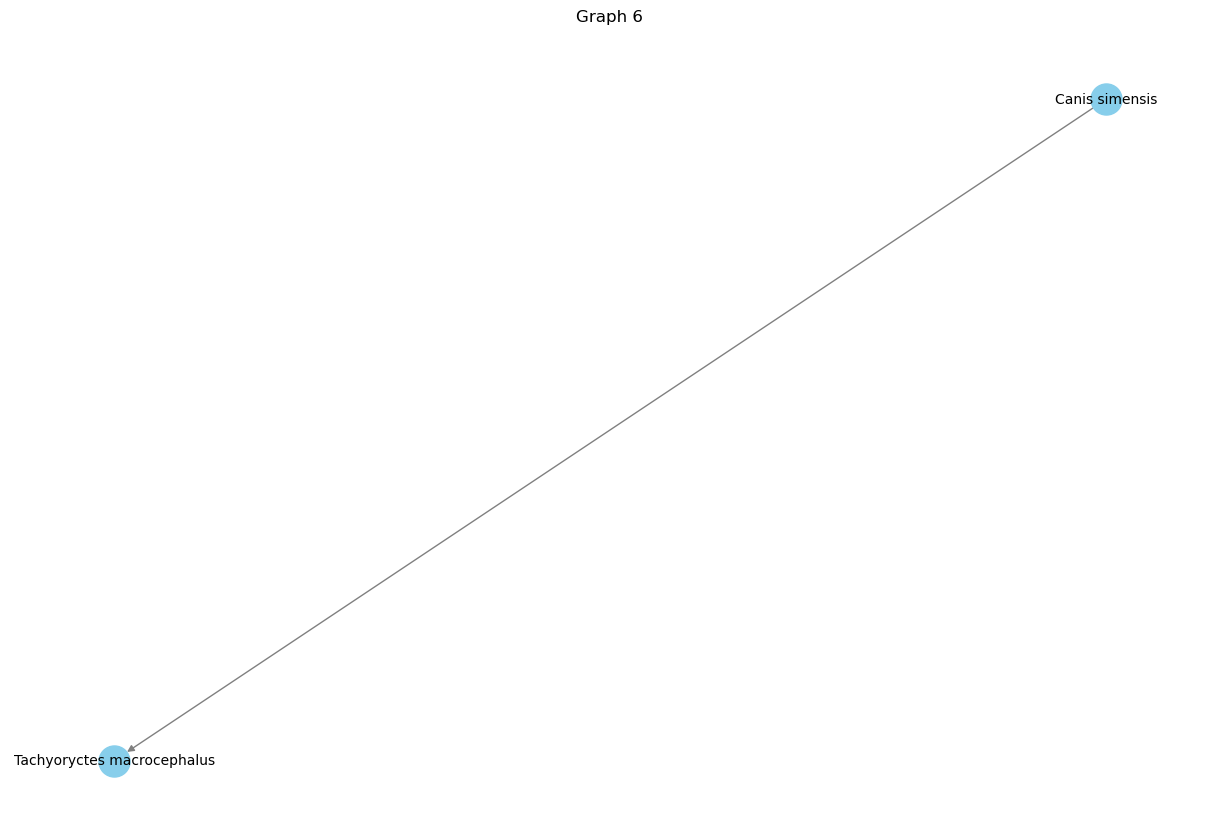

{'Canis simensis': {'Tachyoryctes macrocephalus': -1, 'Canis simensis': 1}, 'Tachyoryctes macrocephalus': {'Tachyoryctes macrocephalus': 1, 'Canis simensis': 1}}
{0: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2bb50>, 2: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b2b0>, 5: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b040>, 6: <networkx.classes.digraph.DiGraph object at 0x7b41d2ff88e0>, 7: <networkx.classes.digraph.DiGraph object at 0x7b41d21759d0>, 8: <networkx.classes.digraph.DiGraph object at 0x7b41d2175a00>, 9: <networkx.classes.digraph.DiGraph object at 0x7b41d21755b0>, 10: <networkx.classes.digraph.DiGraph object at 0x7b41d21755e0>, 12: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fa0>, 13: <networkx.classes.digraph.DiGraph object at 0x7b41d2175b20>, 14: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fd0>, 16: <networkx.classes.digraph.DiGraph object at 0x7b41d2175d90>, 18: <networkx.classes.digraph.DiGraph object at 0x7b41d21756d0>,

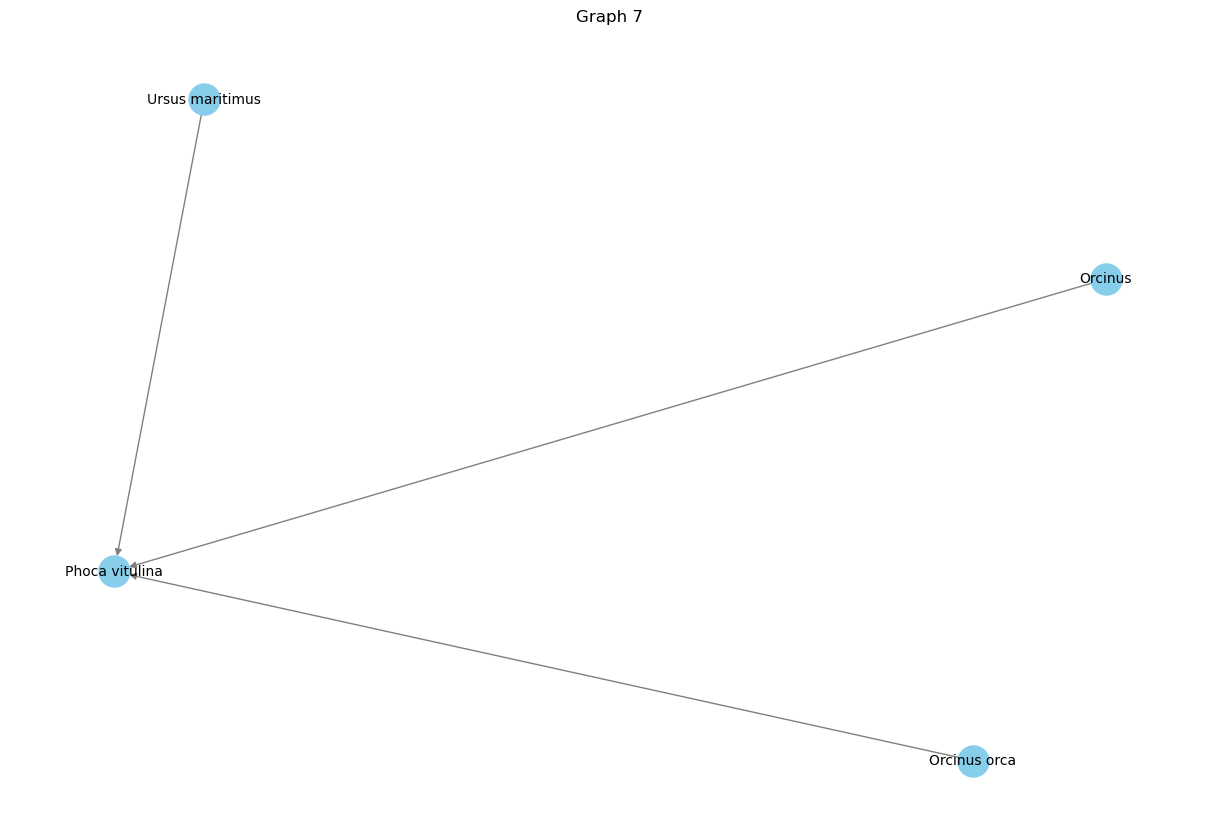

{'Phoca vitulina': {'Orcinus orca': 1, 'Orcinus': 1, 'Ursus maritimus': 1, 'Phoca vitulina': 1}}
{0: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2bb50>, 2: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b2b0>, 5: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b040>, 6: <networkx.classes.digraph.DiGraph object at 0x7b41d2ff88e0>, 7: <networkx.classes.digraph.DiGraph object at 0x7b41d21759d0>, 8: <networkx.classes.digraph.DiGraph object at 0x7b41d2175a00>, 9: <networkx.classes.digraph.DiGraph object at 0x7b41d21755b0>, 10: <networkx.classes.digraph.DiGraph object at 0x7b41d21755e0>, 12: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fa0>, 13: <networkx.classes.digraph.DiGraph object at 0x7b41d2175b20>, 14: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fd0>, 16: <networkx.classes.digraph.DiGraph object at 0x7b41d2175d90>, 18: <networkx.classes.digraph.DiGraph object at 0x7b41d21756d0>, 19: <networkx.classes.digraph.DiGraph object at 0x7b41d2175eb0>,

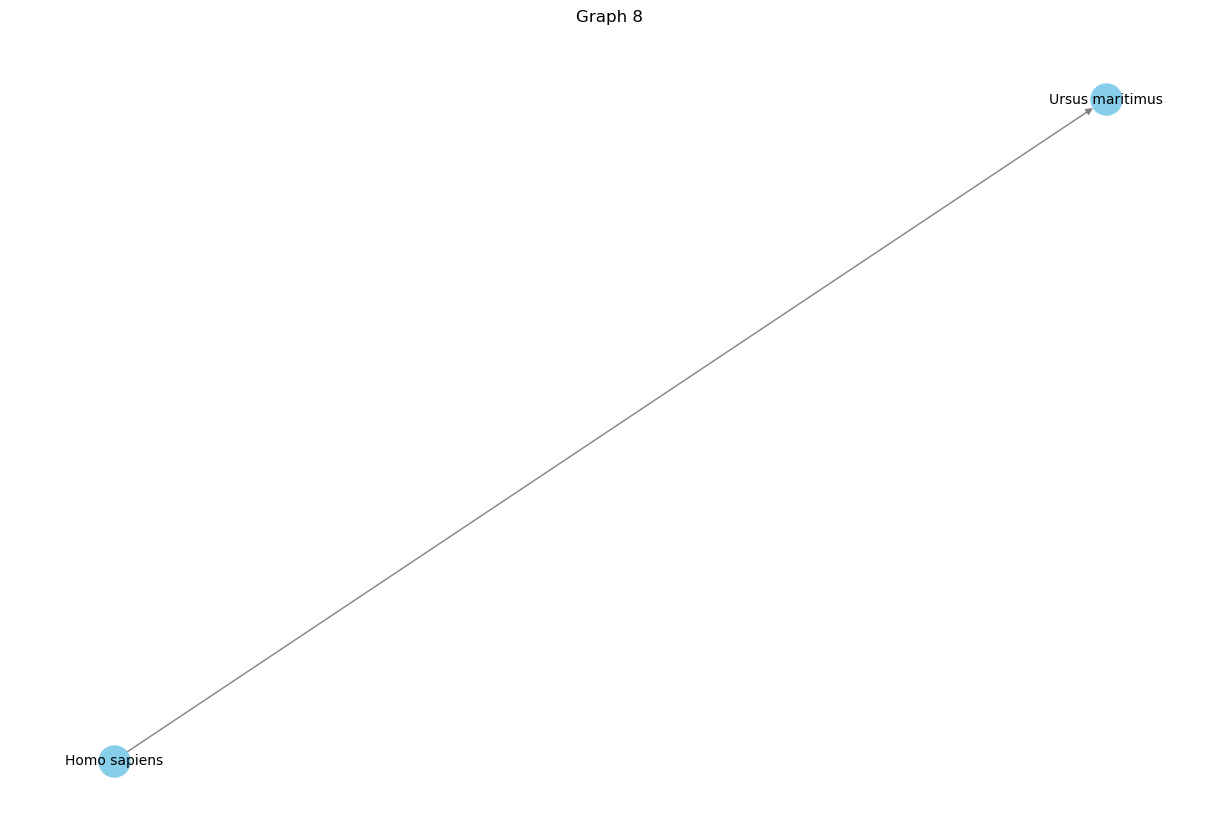

{'Homo sapiens': {'Ursus maritimus': -1, 'Homo sapiens': 1}, 'Ursus maritimus': {'Ursus maritimus': 1, 'Homo sapiens': 1}}
{0: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2bb50>, 2: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b2b0>, 5: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b040>, 6: <networkx.classes.digraph.DiGraph object at 0x7b41d2ff88e0>, 7: <networkx.classes.digraph.DiGraph object at 0x7b41d21759d0>, 8: <networkx.classes.digraph.DiGraph object at 0x7b41d2175a00>, 9: <networkx.classes.digraph.DiGraph object at 0x7b41d21755b0>, 10: <networkx.classes.digraph.DiGraph object at 0x7b41d21755e0>, 12: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fa0>, 13: <networkx.classes.digraph.DiGraph object at 0x7b41d2175b20>, 14: <networkx.classes.digraph.DiGraph object at 0x7b41d2175fd0>, 16: <networkx.classes.digraph.DiGraph object at 0x7b41d2175d90>, 18: <networkx.classes.digraph.DiGraph object at 0x7b41d21756d0>, 19: <networkx.classes.digraph.DiGraph 

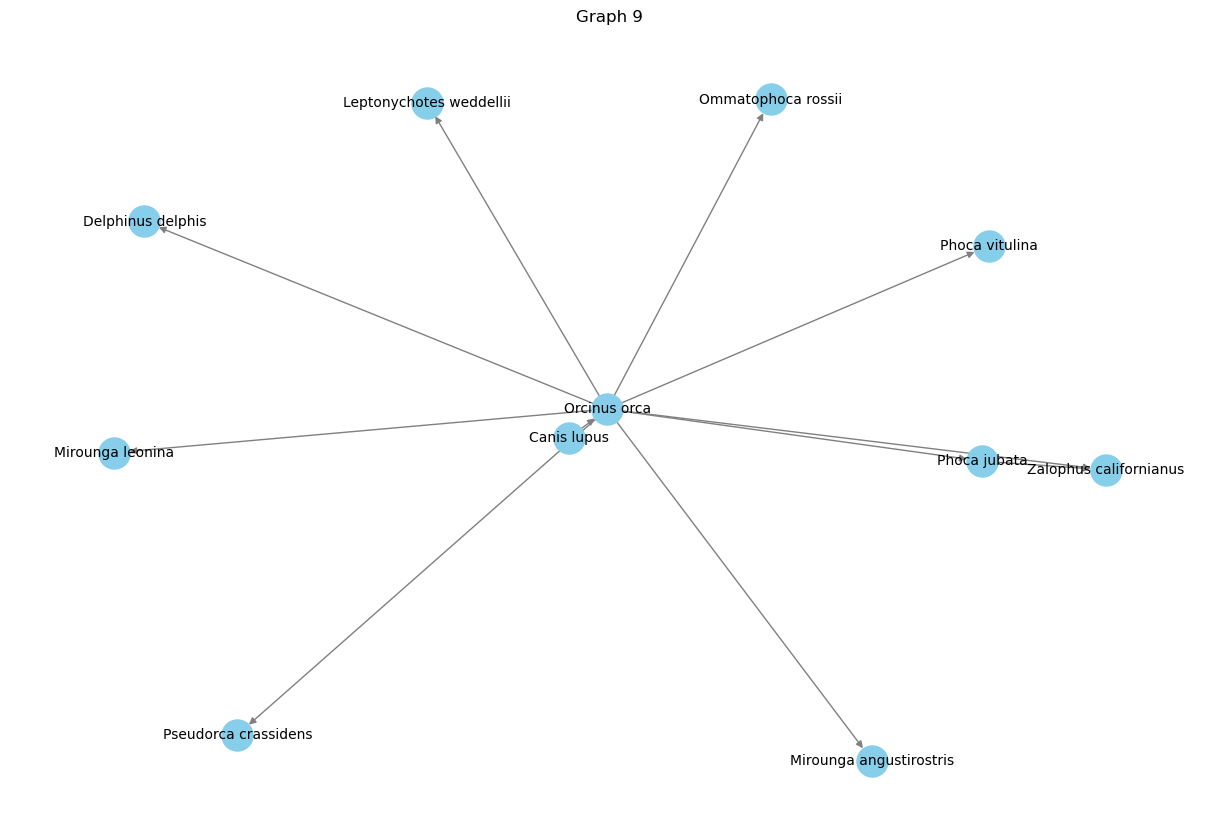

{'Orcinus orca': {'Orcinus orca': 1, 'Zalophus californianus': 0, 'Ommatophoca rossii': -1, 'Phoca vitulina': -1, 'Delphinus delphis': -1, 'Pseudorca crassidens': -1, 'Mirounga leonina': -1, 'Phoca jubata': -1, 'Canis lupus': 1, 'Mirounga angustirostris': -1, 'Leptonychotes weddellii': -1}, 'Phoca jubata': {'Orcinus orca': 0, 'Zalophus californianus': -1, 'Ommatophoca rossii': 0, 'Phoca vitulina': 0, 'Delphinus delphis': 0, 'Pseudorca crassidens': 0, 'Mirounga leonina': 0, 'Phoca jubata': 1, 'Canis lupus': 0, 'Mirounga angustirostris': 0, 'Leptonychotes weddellii': 0}}
{0: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2bb50>, 2: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b2b0>, 5: <networkx.classes.digraph.DiGraph object at 0x7b41d2f2b040>, 6: <networkx.classes.digraph.DiGraph object at 0x7b41d2ff88e0>, 7: <networkx.classes.digraph.DiGraph object at 0x7b41d21759d0>, 8: <networkx.classes.digraph.DiGraph object at 0x7b41d2175a00>, 9: <networkx.classes.digraph.DiGraph ob

In [8]:
i = 0 
for graph_id in fixed_graphs:
    G = fixed_graphs[graph_id]

    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
    plt.title(f"Graph {graph_id}")
    plt.show()

    print(solutions[graph_id]) 
    print(fixed_graphs)

    if i > 5: 
        break 
    i += 1

In [9]:

def get_connected_components_graphs(graph):
    # Get weakly connected components for directed graphs
    connected_components = list(nx.weakly_connected_components(graph))
    
    # Create subgraphs from the connected components
    subgraphs = {}
    for i, component in enumerate(connected_components):
        subgraph = graph.subgraph(component).copy()  # Create a subgraph from the component
        subgraphs[i] = subgraph
    
    return subgraphs, connected_components

def filter_solutions(fixed_graphs, solutions):
    filtered_solutions = {}
    filtered_graphs = {}  # To store the filtered subgraphs
    
    # Create a new index for filtered graphs and solutions to ensure consecutive indices
    new_graph_id = 0
    new_solution_id = 0
    
    for graph_id, graph in fixed_graphs.items():
        # Get the subgraphs and the connected components for the current graph
        subgraphs, connected_components = get_connected_components_graphs(graph)
        
        # Get the largest connected component (based on size)
        largest_component = max(connected_components, key=len)
        
        # Initialize a dictionary to store filtered solutions for the current graph
        filtered_solutions_for_graph = {}
        
        # Iterate through each solution for the current graph
        for node, solution_nodes in solutions.get(graph_id, {}).items():
            # Ensure solution_nodes is not None and filter nodes that are part of the largest component
            if solution_nodes is not None:
                filtered_solution = {k: v for k, v in solution_nodes.items() if k in largest_component}
                
                # Only keep non-empty solutions
                if filtered_solution:
                    filtered_solutions_for_graph[node] = filtered_solution
        
        # Only keep the graph's solutions if any are left after filtering
        if filtered_solutions_for_graph:
            filtered_solutions[new_solution_id] = filtered_solutions_for_graph
            new_solution_id += 1
        
        # Now filter the subgraphs to remove those with empty solutions
        for component_id, subgraph in subgraphs.items():
            # Check if there are any non-empty solutions for the nodes in this subgraph
            subgraph_nodes = set(subgraph.nodes())
            has_non_empty_solution = any(
                node in subgraph_nodes and node in filtered_solutions_for_graph
                for node in filtered_solutions_for_graph
            )
            
            if has_non_empty_solution:
                filtered_graphs[new_graph_id] = subgraph
                new_graph_id += 1
    
    return filtered_solutions, filtered_graphs

# Example usage:
# fixed_graphs = {0: nx.DiGraph(...), 2: nx.DiGraph(...)}  # Directed graph example
# solutions = {0: {'Tonatia bidens': {'Tonatia bidens': 1, 'Myotis': -1}, 'Myotis': {'Tonatia bidens': 1, 'Myotis': 1}}}
filtered_solutions, filtered_graphs = filter_solutions(fixed_graphs, solutions)

print(filtered_graphs)
print(filtered_solutions)


{0: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8790>, 1: <networkx.classes.digraph.DiGraph object at 0x7b41d06c89d0>, 2: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8910>, 3: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8370>, 4: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8bb0>, 5: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8850>, 6: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8b20>, 7: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8610>, 8: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8cd0>, 9: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8490>, 10: <networkx.classes.digraph.DiGraph object at 0x7b41d06c84c0>, 11: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8a60>, 12: <networkx.classes.digraph.DiGraph object at 0x7b41d06c82e0>, 13: <networkx.classes.digraph.DiGraph object at 0x7b41d06c8730>, 14: <networkx.classes.digraph.DiGraph object at 0x7b41d06c85e0>, 15: <networkx.classes.digraph.DiGr

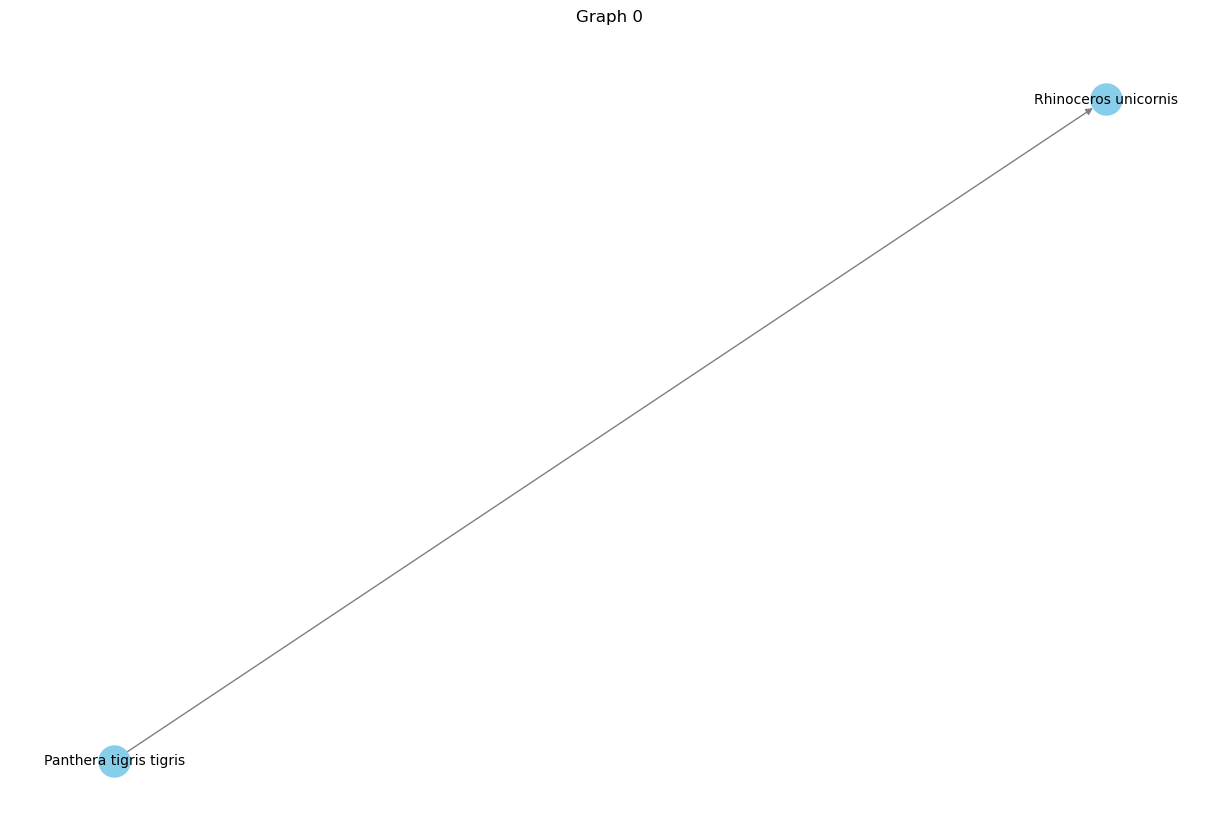

{'Panthera tigris tigris': {'Rhinoceros unicornis': -1, 'Panthera tigris tigris': 1}, 'Rhinoceros unicornis': {'Rhinoceros unicornis': 1, 'Panthera tigris tigris': 1}}


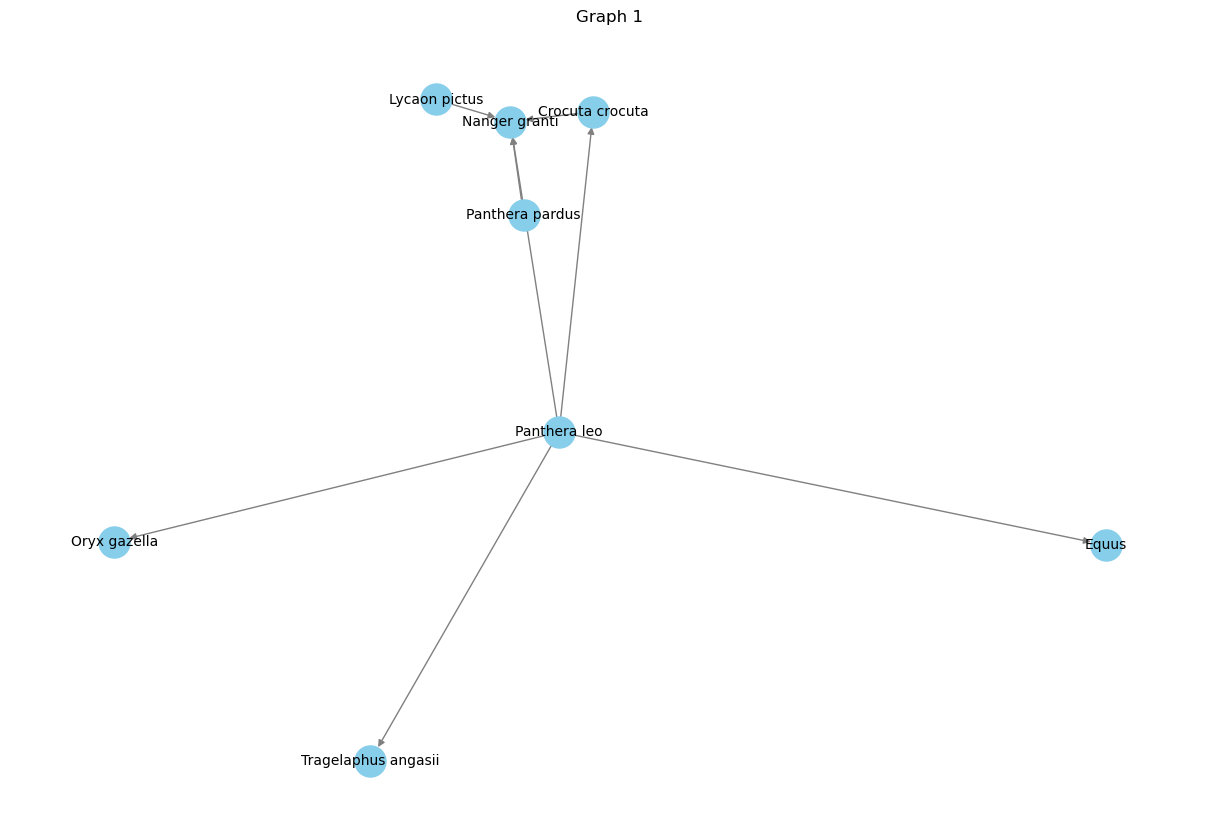

{'Panthera leo': {'Panthera pardus': 0, 'Crocuta crocuta': -1, 'Equus': -1, 'Tragelaphus angasii': -1, 'Lycaon pictus': 0, 'Oryx gazella': -1, 'Panthera leo': 1, 'Nanger granti': 0}}


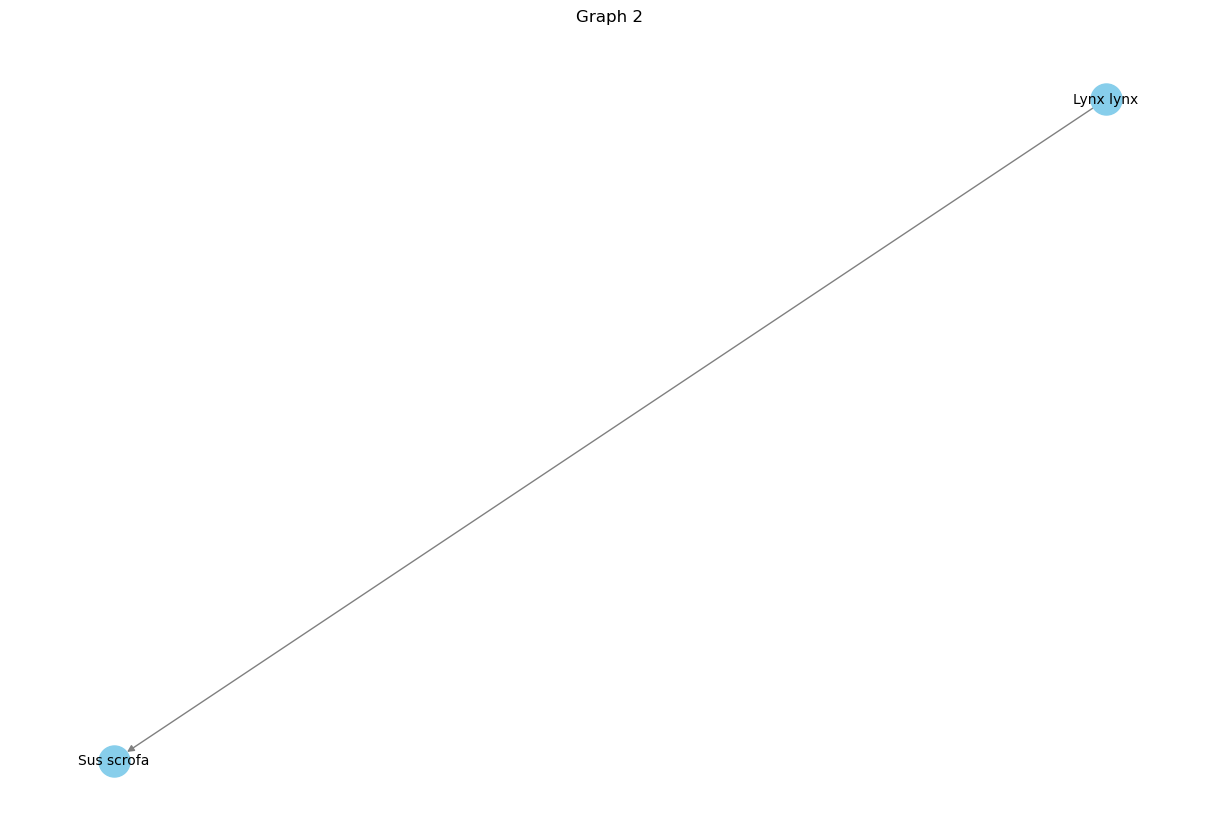

{'Panthera pardus fusca': {'Rhinoceros unicornis': 0, 'Boselaphus tragocamelus': 0, 'Panthera tigris tigris': 0}, 'Lynx lynx': {'Rhinoceros unicornis': 0, 'Boselaphus tragocamelus': 0, 'Panthera tigris tigris': 0}, 'Sus scrofa': {'Rhinoceros unicornis': 0, 'Boselaphus tragocamelus': 0, 'Panthera tigris tigris': 0}, 'Panthera tigris tigris': {'Rhinoceros unicornis': -1, 'Boselaphus tragocamelus': -1, 'Panthera tigris tigris': 1}, 'Macaca mulatta': {'Rhinoceros unicornis': 0, 'Boselaphus tragocamelus': 0, 'Panthera tigris tigris': 0}}


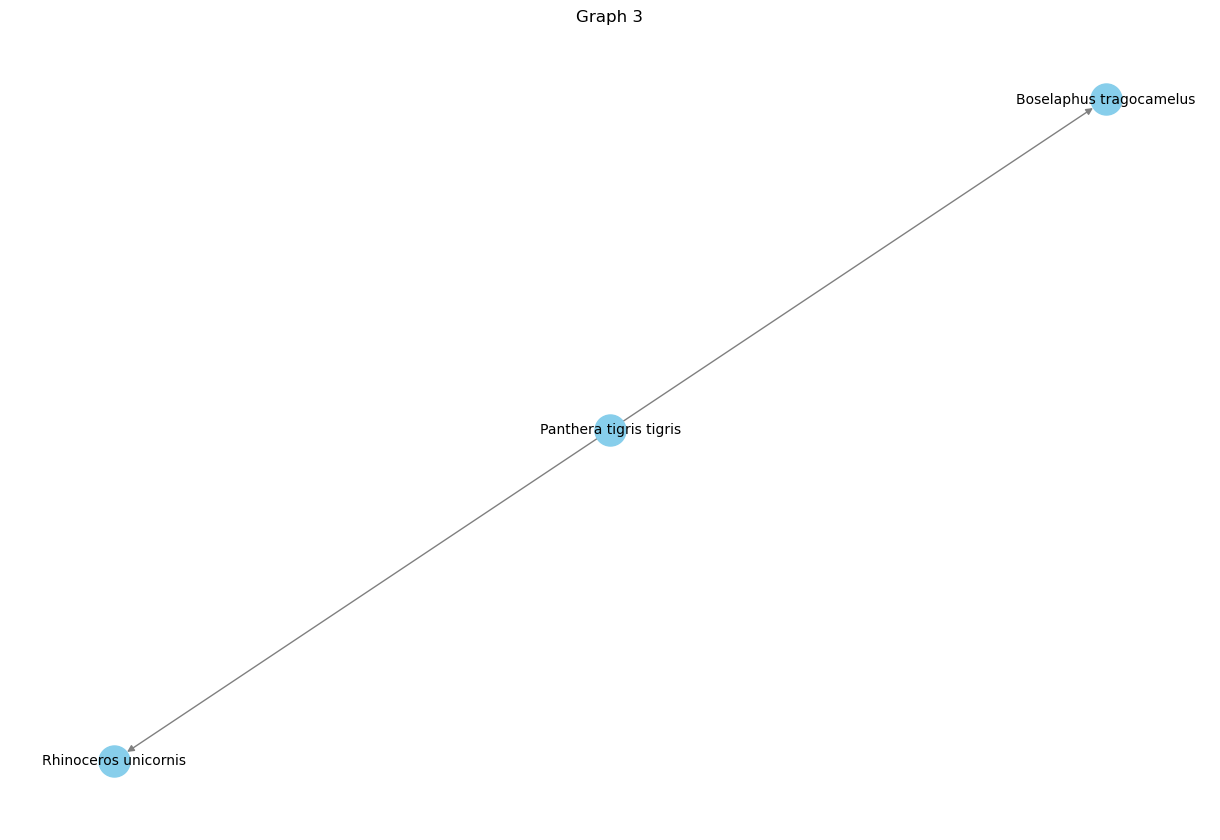

{'Canis simensis': {'Tachyoryctes macrocephalus': -1, 'Canis simensis': 1}, 'Tachyoryctes macrocephalus': {'Tachyoryctes macrocephalus': 1, 'Canis simensis': 1}}


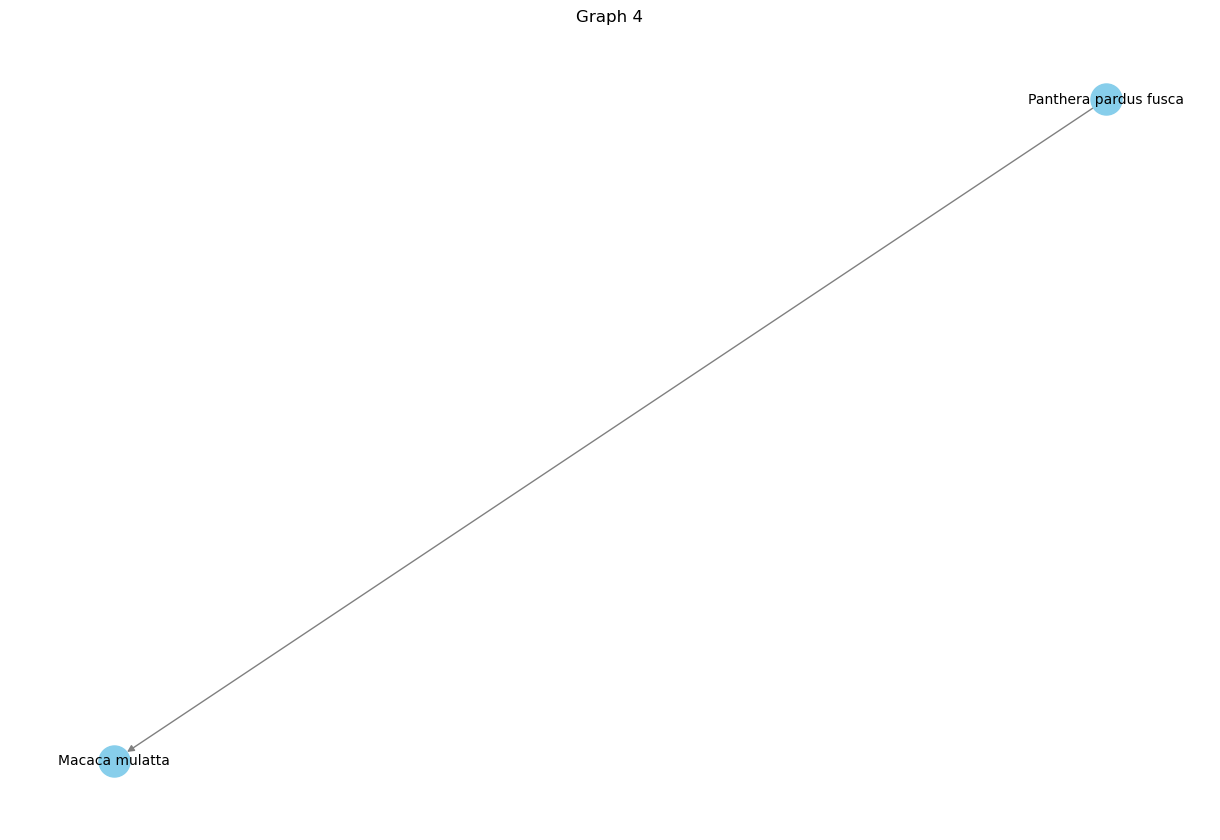

{'Phoca vitulina': {'Orcinus orca': 1, 'Orcinus': 1, 'Ursus maritimus': 1, 'Phoca vitulina': 1}}


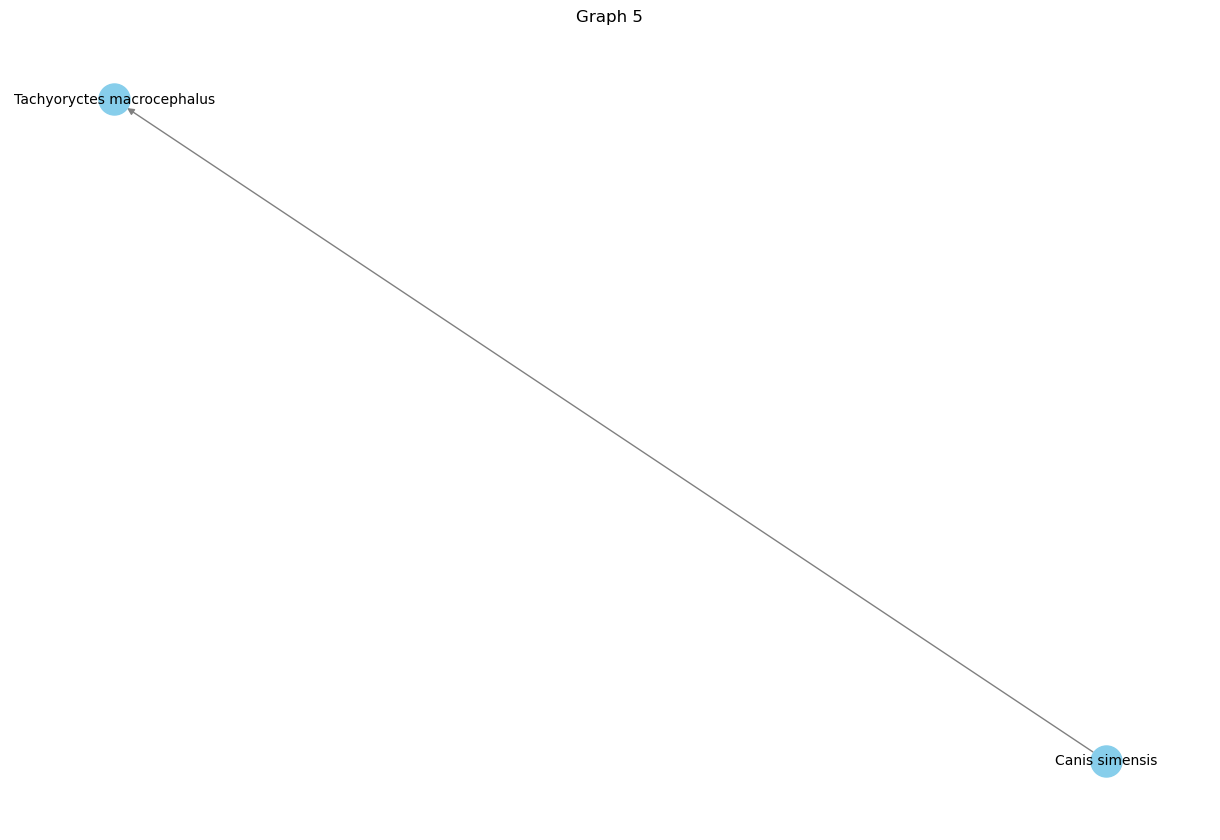

{'Homo sapiens': {'Ursus maritimus': -1, 'Homo sapiens': 1}, 'Ursus maritimus': {'Ursus maritimus': 1, 'Homo sapiens': 1}}


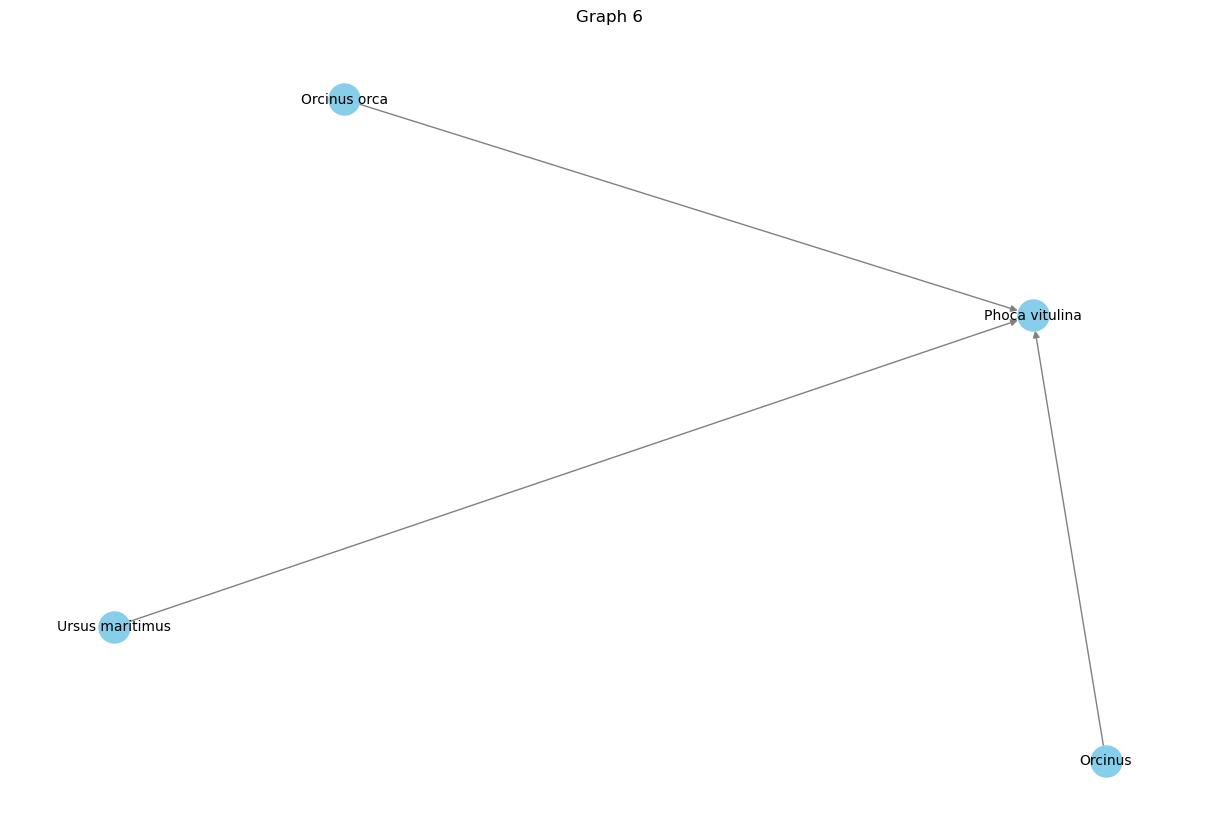

{'Orcinus orca': {'Orcinus orca': 1, 'Zalophus californianus': 0, 'Ommatophoca rossii': -1, 'Phoca vitulina': -1, 'Delphinus delphis': -1, 'Pseudorca crassidens': -1, 'Mirounga leonina': -1, 'Phoca jubata': -1, 'Canis lupus': 1, 'Mirounga angustirostris': -1, 'Leptonychotes weddellii': -1}, 'Phoca jubata': {'Orcinus orca': 0, 'Zalophus californianus': -1, 'Ommatophoca rossii': 0, 'Phoca vitulina': 0, 'Delphinus delphis': 0, 'Pseudorca crassidens': 0, 'Mirounga leonina': 0, 'Phoca jubata': 1, 'Canis lupus': 0, 'Mirounga angustirostris': 0, 'Leptonychotes weddellii': 0}}


In [10]:
i = 0 
for graph_id in filtered_graphs:
    G = filtered_graphs[graph_id]

    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
    plt.title(f"Graph {graph_id}")
    plt.show()

    print(filtered_solutions[graph_id]) 

    if i > 5: 
        break 
    i += 1

In [13]:
def build_dataset(filtered_graphs, filtered_solutions):
    dataset = []
    
    # Iterate over the filtered graphs
    for graph_id, graph in filtered_graphs.items():
        descriptions = describe_subgraph(graph)
        string1 = descriptions["regular"]
        string2 = descriptions["pseudonym"]
        string3 = descriptions["animals"]
        mapping = descriptions["mapping"]
        
        # Convert the mapping list into a dictionary for  lookup
        mapping_dict = {item.split(': ')[0]: item.split(': ')[1] for item in mapping}
        inverted_mapping_dict = {v: k for k, v in mapping_dict.items()}
        
        for solution_key, solution_values in filtered_solutions.get(graph_id, {}).items():
            for solution_value, change in solution_values.items():
                intervention_pseudonym = inverted_mapping_dict.get(solution_key, "")
                target_pseudonym = inverted_mapping_dict.get(solution_value, "")
              
                row = {
                    "graph_id": graph_id,
                    "Prompt_A": string1,
                    "Prompt_B": string2,
                    "Prompt_C": string3,
                    "Intervention": solution_key,
                    "Intervention_pseudonym": intervention_pseudonym, 
                    "Target": solution_value,
                    "Target_pseudonym": target_pseudonym, 
                    "Change": change, 
                    "#Nodes": len(graph.nodes), 
                    "#Edges": len(graph.edges),
                    "Depth": calculate_graph_depth(graph)
                }
                dataset.append(row)
    
    df = pd.DataFrame(dataset)
    df = df[df['Intervention'] != df['Target']]  # Don't be self-referential 
    return df


dataset = build_dataset(filtered_graphs, filtered_solutions)
dataset.to_csv('ecologic_benchmark.csv', index=False)


In [ ]:
# overall we have over about 4000 Dataset entries, this could be made much larger by adding more species or interaction
# types (or better solver code)